# Q1. 모델 비교 분석

# Step 1. Pytorch 데이터 로더 설정

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os

# 전처리 정의 (흑백 이미지가 아닐 경우 3채널 RGB 기준)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# 경로 설정
data_dir = "/content/drive/MyDrive/Xray_image/Xray_image_small"

train_dataset = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=transform)
val_dataset = datasets.ImageFolder(os.path.join(data_dir, "val"), transform=transform)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, "test"), transform=transform)

# 데이터 로더
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 클래스 이름 확인
print("클래스 인식 결과:", train_dataset.classes)

클래스 인식 결과: ['NORMAL', 'PNEUMONIA']


# Step 2: 이미지 시각화 (정상 vs 폐렴)

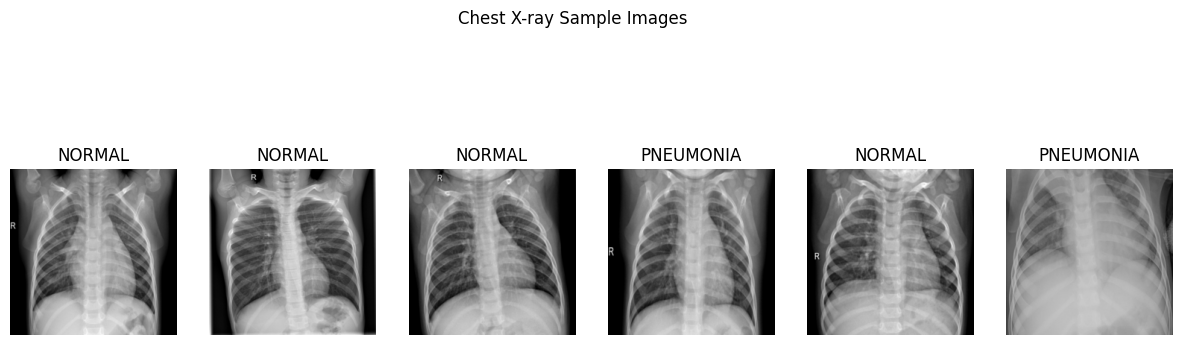

In [ ]:
import matplotlib.pyplot as plt
import torchvision

# 이미지 일부 보기 (grid 형태)
def show_images_from_loader(loader, class_names, n_images=6):
    data_iter = iter(loader)
    images, labels = next(data_iter)

    # n_images만큼 자르기
    images = images[:n_images]
    labels = labels[:n_images]

    # 역정규화
    images = images * 0.5 + 0.5

    # 시각화
    plt.figure(figsize=(15, 5))
    for i in range(n_images):
        img = images[i].permute(1, 2, 0).numpy()
        label = class_names[labels[i].item()]
        plt.subplot(1, n_images, i+1)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')
    plt.suptitle("Chest X-ray Sample Images")
    plt.show()

# 실행
show_images_from_loader(train_loader, train_dataset.classes)

# Step 3: 기본 CNN 모델 정의 및 학습

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class BasicCNN(nn.Module):
    def __init__(self):
        super(BasicCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # -> (16, 112, 112)
        x = self.pool(F.relu(self.conv2(x)))  # -> (32, 56, 56)
        x = x.view(-1, 32 * 56 * 56)
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

In [ ]:
# CNN 모델 학습

import torch
from torch import optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BasicCNN().to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(20):  # 에폭 수 조절 가능
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"[Epoch {epoch+1}] Loss: {running_loss / len(train_loader):.4f}")

[Epoch 1] Loss: 0.6877
[Epoch 2] Loss: 0.6580
[Epoch 3] Loss: 0.5883
[Epoch 4] Loss: 0.5388
[Epoch 5] Loss: 0.5032
[Epoch 6] Loss: 0.4481
[Epoch 7] Loss: 0.4125
[Epoch 8] Loss: 0.3685
[Epoch 9] Loss: 0.3256
[Epoch 10] Loss: 0.2911
[Epoch 11] Loss: 0.2546
[Epoch 12] Loss: 0.2162
[Epoch 13] Loss: 0.1814
[Epoch 14] Loss: 0.1578
[Epoch 15] Loss: 0.1408
[Epoch 16] Loss: 0.1208
[Epoch 17] Loss: 0.1019
[Epoch 18] Loss: 0.0860
[Epoch 19] Loss: 0.0720
[Epoch 20] Loss: 0.0613


In [ ]:
#Accuracy 측정
def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            preds = (outputs > 0.5).int().squeeze()
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    acc = correct / total
    print(f"Validation Accuracy: {acc:.4f}")

# 실행
evaluate(model, val_loader)

Validation Accuracy: 0.6875


# Step 4: Pretrained 모델 활용

In [ ]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

# 사전학습된 DenseNet121 불러오기
densenet = models.densenet121(pretrained=True)

# 마지막 분류 레이어 수정 (binary classification)
num_ftrs = densenet.classifier.in_features
densenet.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 1),
    nn.Sigmoid()
)

densenet = densenet.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 86.2MB/s]


In [ ]:
#학습 준비 - loss, optimizer 정의
criterion = nn.BCELoss()
optimizer = optim.Adam(densenet.parameters(), lr=1e-4)

In [ ]:
for epoch in range(20):  # 에폭 수 조절 가능
    densenet.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        optimizer.zero_grad()
        outputs = densenet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"[Epoch {epoch+1}] Loss: {running_loss / len(train_loader):.4f}")

[Epoch 1] Loss: 0.6392
[Epoch 2] Loss: 0.2913
[Epoch 3] Loss: 0.1502
[Epoch 4] Loss: 0.0923
[Epoch 5] Loss: 0.0542
[Epoch 6] Loss: 0.0471
[Epoch 7] Loss: 0.0361
[Epoch 8] Loss: 0.0217
[Epoch 9] Loss: 0.0148
[Epoch 10] Loss: 0.0115
[Epoch 11] Loss: 0.0097
[Epoch 12] Loss: 0.0084
[Epoch 13] Loss: 0.0117
[Epoch 14] Loss: 0.0062
[Epoch 15] Loss: 0.0088
[Epoch 16] Loss: 0.0050
[Epoch 17] Loss: 0.0056
[Epoch 18] Loss: 0.0070
[Epoch 19] Loss: 0.0039
[Epoch 20] Loss: 0.0034


In [ ]:
def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            preds = (outputs > 0.5).int().squeeze()
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    acc = correct / total
    print(f"Accuracy: {acc:.4f}")

# 실행
print("Validation Set:")
evaluate(densenet, val_loader)
print("Test Set:")
evaluate(densenet, test_loader)

Validation Set:
Accuracy: 0.7500
Test Set:
Accuracy: 0.6167


#Step 5: 결과 정리

In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# 모델 평가 모드
densenet.eval()

# 예측 결과 저장용 리스트
all_preds = []
all_probs = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = densenet(inputs)

        probs = outputs.cpu().numpy().flatten()
        preds = (outputs > 0.5).int().cpu().numpy().flatten()
        labels = labels.cpu().numpy().flatten()

        all_probs.extend(probs)
        all_preds.extend(preds)
        all_labels.extend(labels)

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
all_probs = np.array(all_probs)

<Figure size 600x600 with 0 Axes>

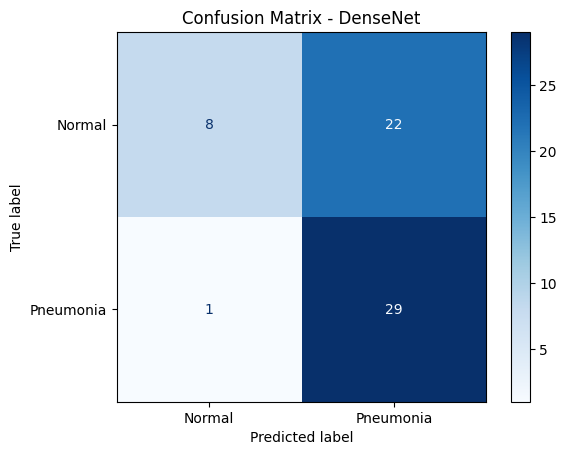

In [ ]:
# 혼동 행렬 계산
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Pneumonia"])

# 시각화
plt.figure(figsize=(6, 6))
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix - DenseNet")
plt.grid(False)
plt.show()

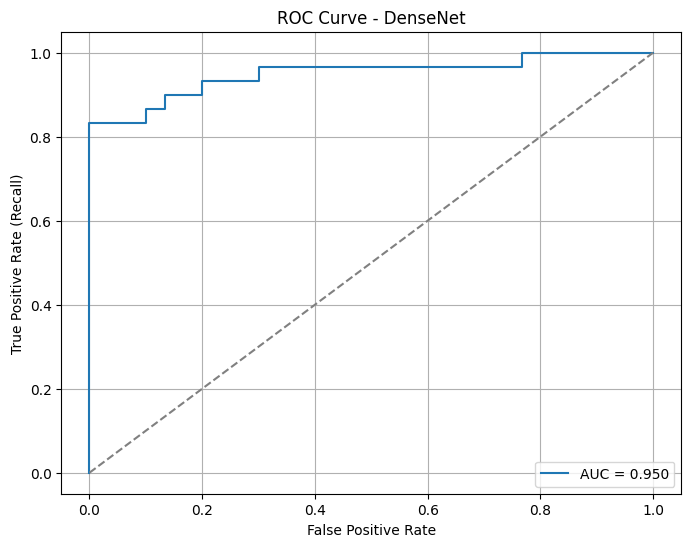

In [ ]:
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = roc_auc_score(all_labels, all_probs)

# 시각화
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve - DenseNet")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Step 6: GradCAM 시각화 - 해석력 강화

In [ ]:
# 1. Grad-CAM 유틸리티 함수
import cv2
def generate_gradcam(model, input_tensor, target_class, target_layer):
    model.eval()
    gradients = []
    activations = []

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0].detach())

    def forward_hook(module, input, output):
        activations.append(output.detach())

    # Hook 등록
    handle_fw = target_layer.register_forward_hook(forward_hook)
    handle_bw = target_layer.register_backward_hook(backward_hook)

    # Forward
    output = model(input_tensor)
    model.zero_grad()
    loss = output[0][0] if target_class is None else output[0, target_class]
    loss.backward()

    # Hook 해제
    handle_fw.remove()
    handle_bw.remove()

    # Grad-CAM 계산
    grads = gradients[0]  # shape: [B, C, H, W]
    acts = activations[0] # shape: [B, C, H, W]
    pooled_grads = torch.mean(grads, dim=[0, 2, 3])  # shape: [C]

    # weighted sum
    for i in range(acts.shape[1]):
        acts[:, i, :, :] *= pooled_grads[i]

    heatmap = torch.mean(acts, dim=1).squeeze()
    heatmap = np.maximum(heatmap.cpu().numpy(), 0)
    heatmap /= np.max(heatmap)
    return heatmap

In [ ]:
#예측값 & 정답 필터링 → 폐렴을 정확히 맞춘 샘플 찾기
correct_indices = []
sample_imgs = []
sample_labels = []

# test_dataset 전체 탐색
for i in range(len(test_dataset)):
    img, label = test_dataset[i]
    input_tensor = img.unsqueeze(0).to(device)

    with torch.no_grad():
        output = densenet(input_tensor)
        pred = (output > 0.5).int().item()

    # 폐렴이고 예측도 폐렴이면 저장
    if label == 1 and pred == 1:
        correct_indices.append(i)
        sample_imgs.append(img)
        sample_labels.append(label)

print(f"폐렴 → 폐렴으로 정확히 맞춘 샘플 개수: {len(correct_indices)}개")

폐렴 → 폐렴으로 정확히 맞춘 샘플 개수: 29개


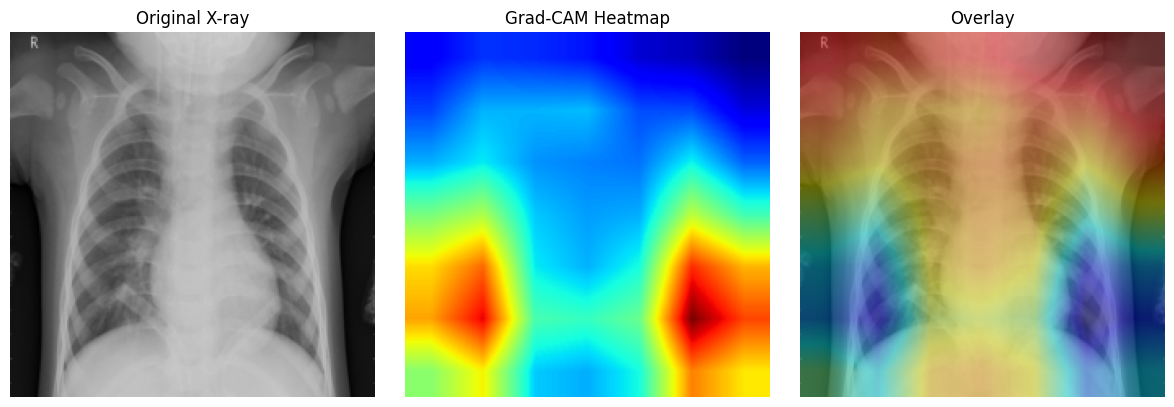

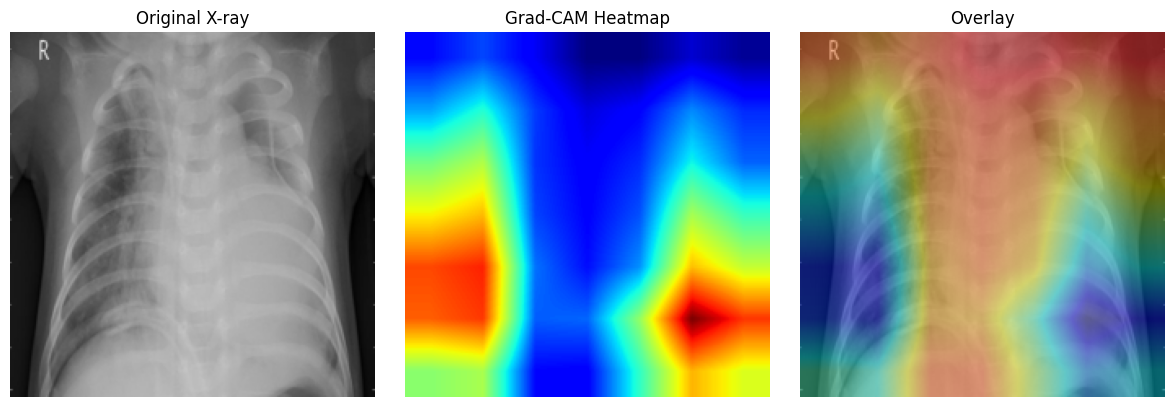

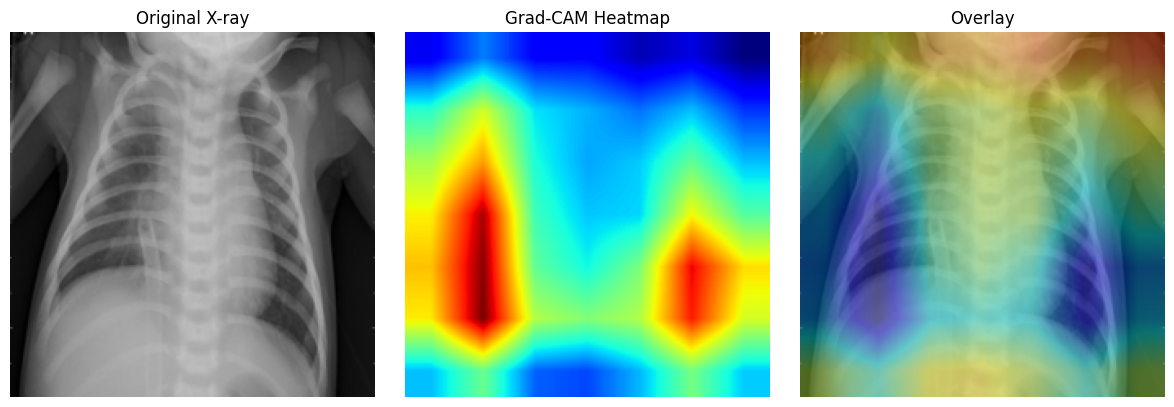

In [ ]:
#2) Grad-CAM 적용 예제 (DenseNet의 마지막 conv layer 사용)
# 예: 맞춘 것 중 0~2번 샘플 시각화
import cv2
import numpy as np
import matplotlib.pyplot as plt

for i in range(min(3, len(sample_imgs))):  # 최대 3개까지만 예시
    img = sample_imgs[i]
    input_tensor = img.unsqueeze(0).to(device)

    heatmap = generate_gradcam(densenet, input_tensor, target_class=None, target_layer=densenet.features[-1])

    # 원본 이미지
    img_np = img.permute(1, 2, 0).numpy()
    img_np = img_np * 0.5 + 0.5  # 역정규화

    # Heatmap → 컬러맵 적용
    heatmap_resized = cv2.resize(heatmap, (img_np.shape[1], img_np.shape[0]))
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    overlay = 0.4 * heatmap_colored / 255.0 + 0.6 * img_np

    # 시각화
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(img_np)
    plt.title("Original X-ray")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(heatmap_resized, cmap='jet')
    plt.title("Grad-CAM Heatmap")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(np.clip(overlay, 0, 1))
    plt.title("Overlay")
    plt.axis('off')
    plt.tight_layout()
    plt.show()